# Performance protopipe

**Purpose of this notebook:**

Open IRF and Sensitivity computed by pyirf from DL2 files produced by protopipe

**Notes:**

The following results correspond to:

- La Palma site
- Zd 20 deg, Az 180 deg
- 50 h observation time

## Table of contents

* [Optimized cuts](#Optimized-cuts)
    - [Direction cut](#Direction-cut)
* [Differential sensitivity from cuts optimization](#Differential-sensitivity-from-cuts-optimization)
* [IRFs](#IRFs)
    - [Effective area](#Effective-area)
    - [Point Spread Function](#Point-Spread-Function)
        + [Angular resolution](#Angular-resolution)
    - [Energy dispersion](#Energy-dispersion)
        + [Energy resolution](#Energy-resolution)
    - [Background rate](#Background-rate)

## Imports

In [13]:
import os

import numpy as np
#import uproot
from astropy.io import fits
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.table import QTable
from matplotlib.ticker import ScalarFormatter
from astropy.table import Table, Column
from gammapy.irf import EffectiveAreaTable, EnergyDispersion2D
from matplotlib import gridspec

%matplotlib inline

In [14]:
plt.rcParams['figure.figsize'] = (9, 6)

## Functions

In [15]:
def get_performance(filename):
    """
    Load IRF, use Gammapy capabilities to handle the miragtion matrix
    """
    with fits.open(filename, memmap=False) as hdulist:
        aeff = EffectiveAreaTable.from_hdulist(hdulist=hdulist).to_table()
        bkg = Table.read(hdulist["BACKGROUND"])
        psf = Table.read(hdulist["POINT SPREAD FUNCTION"])
        sens = Table.read(hdulist["SENSITIVITY"])
        edisp = EnergyDispersion2D.read(filename, hdu="ENERGY DISPERSION")
        rmf = edisp.to_energy_dispersion(offset=0.5 * u.deg)  # Projection of migration matrix, dummy angle...

        try:  # Collection area without score/angular cut
            aeff_no_cuts = Table.read(hdulist["SPECRESP (NO CUTS)"])
            aeff_angular_cut = Table.read(hdulist["SPECRESP (WITH ANGULAR CUT)"])
            aeff_score_cut = Table.read(hdulist["SPECRESP (WITH SCORE CUT)"])

            aeff_no_cuts.columns['SPECRESP (NO CUTS)'].name = 'SPECRESP'
            aeff_angular_cut["SPECRESP (WITH ANGULAR CUT)"].name = 'SPECRESP'
            aeff_score_cut["SPECRESP (WITH SCORE CUT)"].name = 'SPECRESP'
        except:
            pass

    # Collection area without score/angular cut, that will be used to contain the IRF
    perf = dict(aeff= aeff, bkg= bkg, psf= psf, rmf=rmf, sens=sens, edisp=edisp)

    try:
        perf['aeff_no_cuts'] = aeff_no_cuts
        perf['aeff_angular_cut'] = aeff_angular_cut
        perf['aeff_score_cut'] = aeff_score_cut
    except:
        pass

    return perf

In [16]:
def plot_table(t, colname, label, energy_range, **kwargs):
    """Simple function to plot an astropy table"""
    centers = np.sqrt(t['ENERG_LO'] * t['ENERG_HI'])
    bin_width = t['ENERG_HI'] - t['ENERG_LO']
    err_plus = t['ENERG_HI'] - centers
    err_minus = centers - t['ENERG_LO']
    values = t[colname]

    # Selection bins in the energy range
    idx = np.where( (centers >= energy_range[0]) & (centers <= energy_range[-1]) )
    plt.errorbar(centers[idx], values[idx], xerr=(err_minus[idx],err_plus[idx]), label=label, **kwargs)



In [17]:
def plot_energy_response(rmf, label, energy_range, **kwargs):
    """Simple function to plot the energy resolution (Gammapy)"""
    energy = rmf.e_true.nodes
    bias = rmf.get_bias(energy)
    resol = rmf.get_resolution(energy)

    idx = np.where( (energy.value >= energy_range[0]) & (energy.value <= energy_range[-1]) )

    plt.errorbar(energy.value[idx], bias[idx], **kwargs, ls='--')
    plt.errorbar(energy.value[idx], resol[idx], label=label, **kwargs, ls='-')

## Input data

## Requirements

In [18]:
indir = '../../data/requirements'

# Full array
infiles = dict(
    SENSITIVITY='/North-50h.dat',
    ANGULAR_RESOLUTION='/North-50h-AngRes.dat',
    ENERGY_RESOLUTION='/North-50h-ERes.dat',
    #EFFECTIVE_AREA='North-50h-EffectiveArea.dat',
    )
requirements = dict()

for key in infiles.keys():
    requirements[key] = Table.read(indir + infiles[key], format='ascii')

for key in infiles.keys():
    requirements[key].add_column(Column(data=(10**requirements[key]['col1']), name='ENERGY'))
    requirements[key].add_column(Column(data=requirements[key]['col2'], name=key))


## MARS Performance

In [19]:
indir = '../../data/MARS_Analysis/point-like/LaPalma_20_South/'
indir = os.path.expandvars(indir)

filenames = {
    '50h': 'CTA-Performance-North-20deg-S-onaxis-50h_20170627.fits.gz'
}
perf_mars_fullarray = dict()
for key in filenames.keys():
    perf_mars_fullarray[key] = get_performance(os.path.join(indir, filenames[key]))

TypeError: the Quantity implementation cannot handle <function digitize at 0x7fee39772320> with the given arguments.

## _pyirf_

The following is the current IRF + sensititivy output FITS format provided by this software.

Run `python examples/calculate_protopipe_irfs.py` after downloading the data

In [20]:
pyirf_file = '../../pyirf_protopipe.fits.gz'

## Optimized cuts
[back to top](#Table-of-contents)

### Direction cut
[back to top](#Table-of-contents)

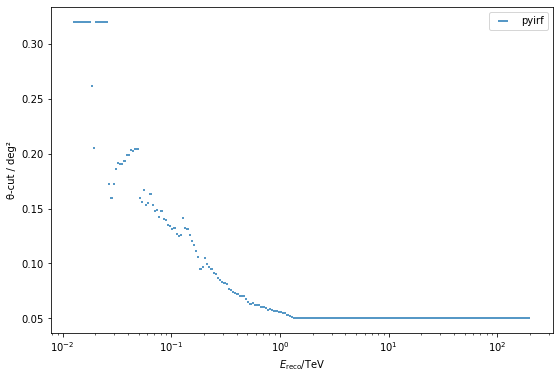

In [21]:
from astropy.table import QTable


rad_max = QTable.read(pyirf_file, hdu='RAD_MAX')[0]

plt.errorbar(
    0.5 * (rad_max['ENERG_LO'] + rad_max['ENERG_HI'])[1:-1].to_value(u.TeV),
    rad_max['RAD_MAX'].T[1:-1, 0].to_value(u.deg),
    xerr=0.5 * (rad_max['ENERG_HI'] - rad_max['ENERG_LO'])[1:-1].to_value(u.TeV),
    ls='',
    label='pyirf',
)

plt.legend()
plt.ylabel('θ-cut / deg²')
plt.xlabel(r'$E_\mathrm{reco} / \mathrm{TeV}$')
plt.xscale('log')

None # to remove clutter by mpl objects

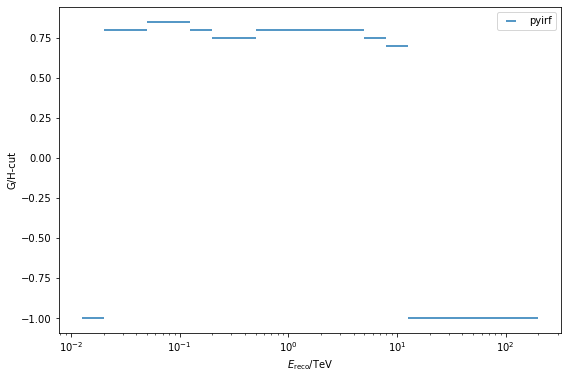

In [22]:
from astropy.table import QTable


gh_cut = QTable.read(pyirf_file, hdu='GH_CUTS')[1:-1]


plt.errorbar(
    0.5 * (gh_cut['low'] + gh_cut['high']).to_value(u.TeV),
    gh_cut['cut'],
    xerr=0.5 * (gh_cut['high'] - gh_cut['low']).to_value(u.TeV),
    ls='',
    label='pyirf',
)

plt.legend()
plt.ylabel('G/H-cut')
plt.xlabel(r'$E_\mathrm{reco} / \mathrm{TeV}$')
plt.xscale('log')

None # to remove clutter by mpl objects

## Differential sensitivity from cuts optimization
[back to top](#Table-of-contents)

In [23]:
# [1:-1] removes under/overflow bins
sensitivity = QTable.read(pyirf_file, hdu='SENSITIVITY')[1:-1]

# make it print nice
sensitivity['reco_energy_low'].info.format = '.3g'
sensitivity['reco_energy_high'].info.format = '.3g'
sensitivity['reco_energy_center'].info.format = '.3g'
sensitivity['n_signal'].info.format = '.1f'
sensitivity['n_signal_weighted'].info.format = '.1f'
sensitivity['n_background_weighted'].info.format = '.1f'
sensitivity['n_background'].info.format = '.1f'
sensitivity['relative_sensitivity'].info.format = '.2g'
sensitivity['flux_sensitivity'].info.format = '.3g'


sensitivity

reco_energy_low,reco_energy_high,reco_energy_center,n_signal,n_background,n_signal_weighted,n_background_weighted,failed_checks,relative_sensitivity,flux_sensitivity
TeV,TeV,TeV,,,,,,,1 / (cm2 s TeV)
float64,float64,float64,float64,float64,float64,float64,int64,float64,float64
0.0126,0.02,0.0163,71.6,1.5,140.2,3011.7,4,nan,nan
0.02,0.0316,0.0258,49.3,1.9,63.4,554.4,0,0.045,1.86e-08
0.0316,0.0501,0.0409,502.2,97.2,508.9,42174.2,0,0.01,1.28e-09
0.0501,0.0794,0.0648,139.1,8.7,99.6,1465.5,0,0.025,9.04e-10
0.0794,0.126,0.103,213.8,16.3,119.1,2139.5,0,0.014,1.52e-10
0.126,0.2,0.163,676.6,111.5,291.9,13637.9,0,0.008,2.62e-11
0.2,0.316,0.258,921.5,160.9,284.9,12983.8,0,0.0093,9.14e-12
0.316,0.501,0.409,765.3,106.8,176.2,4839.2,0,0.0097,2.87e-12


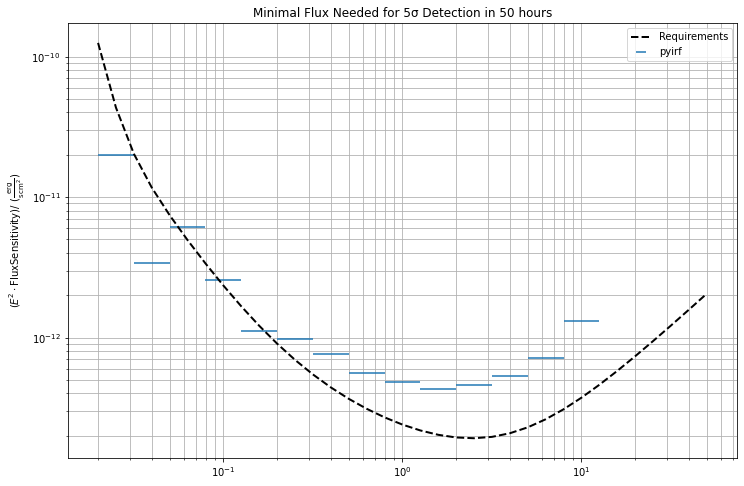

In [24]:
plt.figure(figsize=(12,8))

# pyirf
unit = u.Unit('erg cm-2 s-1')
e = sensitivity['reco_energy_center']
s = (e**2 * sensitivity['flux_sensitivity'])
w = (sensitivity['reco_energy_high'] - sensitivity['reco_energy_low'])
plt.errorbar(
    e.to_value(u.TeV),
    s.to_value(unit),
    xerr=w.to_value(u.TeV) / 2,
    ls='',
    label='pyirf'
)

# Requirements
plt.plot(requirements['SENSITIVITY']['ENERGY'],
             requirements['SENSITIVITY']['SENSITIVITY'],
             color='black',
             ls='--',
             lw=2,
             label='Requirements')

# Style settings
plt.title('Minimal Flux Needed for 5σ Detection in 50 hours')
plt.xscale("log")
plt.yscale("log")
plt.ylabel(rf"$(E^2 \cdot \mathrm{{Flux Sensitivity}}) /$ ({unit.to_string('latex')})")

plt.grid(which="both")
plt.legend()

None # to remove clutter by mpl objects

## IRFs
[back to top](#Table-of-contents)

### Effective area
[back to top](#Table-of-contents)

In [ ]:
# Data pyirf
for name in ('', '_NO_CUTS', '_ONLY_GH', '_ONLY_THETA'):

    area = QTable.read(pyirf_file, hdu='EFFECTIVE_AREA' + name)[0]

    
    plt.errorbar(
        0.5 * (area['ENERG_LO'] + area['ENERG_HI']).to_value(u.TeV)[1:-1],
        area['EFFAREA'].to_value(u.m**2).T[1:-1, 0],
        xerr=0.5 * (area['ENERG_LO'] - area['ENERG_HI']).to_value(u.TeV)[1:-1],
        ls='',
        label='pyirf ' + name,
    )

# Reference data: MARS
plot_table(
    perf_mars_fullarray['50h']['aeff'], 
    'SPECRESP', label='MARS', 
    energy_range =[0.01, 51.], 
    **{'color': 'darkblue', 'lw': 2})

# Style settings
plt.xscale("log")
plt.yscale("log")
plt.xlabel("True energy / TeV")
plt.ylabel("Effective collection area / m²")
plt.grid(which="both")
plt.legend()

None # to remove clutter by mpl objects

### Point Spread Function
[back to top](#Table-of-contents)

In [ ]:
psf_table

In [ ]:
psf_table = QTable.read(pyirf_file, hdu='PSF')[0]
# select the only fov offset bin
psf = psf_table['RPSF'].T[:, 0, :].to_value(1 / u.sr)

offset_bins = np.append(psf_table['RAD_LO'], psf_table['RAD_HI'][-1])
phi_bins = np.linspace(0, 2 * np.pi, 100)



# Let's make a nice 2d representation of the radially symmetric PSF
r, phi = np.meshgrid(offset_bins.to_value(u.deg), phi_bins)

# look at a single energy bin
# repeat values for each phi bin
center = 0.5 * (psf_table['ENERG_LO'] + psf_table['ENERG_HI'])


fig = plt.figure(figsize=(15, 5))
axs = [fig.add_subplot(1, 3, i, projection='polar') for i in range(1, 4)]


for bin_id, ax in zip([10, 20, 30], axs):
    image = np.tile(psf[bin_id], (len(phi_bins) - 1, 1))
    
    ax.set_title(f'PSF @ {center[bin_id]:.2f} TeV')
    ax.pcolormesh(phi, r, image)
    ax.set_ylim(0, 0.25)
    ax.set_aspect(1)
    
fig.tight_layout()

None # to remove clutter by mpl objects

In [ ]:
# Profile
center = 0.5 * (offset_bins[1:] + offset_bins[:-1])
xerr = 0.5 * (offset_bins[1:] - offset_bins[:-1])

for bin_id in [10, 20, 30]:
    plt.errorbar(
        center.to_value(u.deg),
        psf[bin_id],
        xerr=xerr.to_value(u.deg),
        ls='',
        label=f'Energy Bin {bin_id}'
    )
    
#plt.yscale('log')
plt.legend()
plt.xlim(0, 0.25)
plt.ylabel('PSF PDF / sr⁻¹')
plt.xlabel('Distance from True Source / deg')

None # to remove clutter by mpl objects

#### Angular resolution
[back to top](#Table-of-contents)

In [ ]:
# pyirf
ang_res = QTable.read(pyirf_file, hdu='ANGULAR_RESOLUTION')[1:-1]

plt.errorbar(
    0.5 * (ang_res['true_energy_low'] + ang_res['true_energy_high']).to_value(u.TeV),
    ang_res['angular_resolution'].to_value(u.deg),
    xerr=0.5 * (ang_res['true_energy_high'] - ang_res['true_energy_low']).to_value(u.TeV),
    ls='',
    label='pyirf'
)

# Style settings
plt.xlim(1.e-2, 2.e2)
plt.ylim(2.e-2, 1)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("True energy / TeV")
plt.ylabel("Angular Resolution / deg")
plt.grid(which="both")
plt.legend(loc="best")

None # to remove clutter by mpl objects

In [ ]:
# pyirf
# Vorrei la PSF i funzione dell'energia ricostruita
ang_res = QTable.read(pyirf_file, hdu='ANGULAR_RESOLUTION')[1:-1]

plt.errorbar(
    0.5 * (ang_res['true_energy_low'] + ang_res['true_energy_high']).to_value(u.TeV),
    ang_res['angular_resolution'].to_value(u.deg),
    xerr=0.5 * (ang_res['true_energy_high'] - ang_res['true_energy_low']).to_value(u.TeV),
    ls='',
    label='pyirf'
)

# Reference data: MARS
plot_table(
    perf_mars_fullarray['50h']['psf'], 
    'PSF68', label='MARS', 
    energy_range =[0.01, 51.], 
    **{'color': 'darkblue', 'lw': 2})


# Requirements
plt.plot(requirements['ANGULAR_RESOLUTION']['ENERGY'],
             requirements['ANGULAR_RESOLUTION']['ANGULAR_RESOLUTION'],
             color='black',
             ls='--',
             lw=2,
             label='Requirements')



# Style settings
plt.xlim(1.e-2, 2.e2)
plt.ylim(2.e-2, 1)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("True energy / TeV")
plt.ylabel("Angular Resolution / deg")
plt.grid(which="both")
plt.legend(loc="best")



None # to remove clutter by mpl objects

### Energy dispersion
[back to top](#Table-of-contents)

In [ ]:
edisp = QTable.read(pyirf_file, hdu='ENERGY_DISPERSION')[0]

e_bins = edisp['ENERG_LO'][1:]
migra_bins = edisp['MIGRA_LO'][1:]

plt.title('pyirf')
plt.pcolormesh(e_bins.to_value(u.TeV), migra_bins, edisp['MATRIX'].T[1:-1, 1:-1, 0].T, cmap='inferno')

plt.xscale('log')
plt.yscale('log')
plt.colorbar(label='PDF Value')

plt.xlabel(r'$E_\mathrm{True} / \mathrm{TeV}$')
plt.ylabel(r'$E_\mathrm{Reco} / E_\mathrm{True}$')

None # to remove clutter by mpl objects

#### Energy resolution
[back to top](#Table-of-contents)

In [ ]:
perf_mars_fullarray['50h']['edisp']

In [ ]:
# pyirf
bias_resolution = QTable.read(pyirf_file, hdu='ENERGY_BIAS_RESOLUTION')[1:-1]

plt.errorbar(
    0.5 * (bias_resolution['true_energy_low'] + bias_resolution['true_energy_high']).to_value(u.TeV),
    bias_resolution['resolution'],
    xerr=0.5 * (bias_resolution['true_energy_high'] - bias_resolution['true_energy_low']).to_value(u.TeV),
    ls='',
    label='pyirf'
)
plt.xscale('log')

# Requirements
plt.plot(requirements['ENERGY_RESOLUTION']['ENERGY'],
             requirements['ENERGY_RESOLUTION']['ENERGY_RESOLUTION'],
             color='black',
             ls='--',
             lw=2,
             label='Requirements')

# Reference data: MARS
plot_energy_response(
    perf_mars_fullarray['50h']['rmf'], 
    label='MARS', 
    energy_range =[0.01, 51.], 
    **{'color': 'darkblue', 'lw': 2})

# Style settings
plt.xlabel(r"$E_\mathrm{True} / \mathrm{TeV}$")
plt.ylabel("Energy resolution")
plt.grid(which="both")
plt.legend(loc="best")

None # to remove clutter by mpl objects

### Background rate
[back to top](#Table-of-contents)

In [ ]:
from pyirf.utils import cone_solid_angle

# pyirf data
bg_rate = QTable.read(pyirf_file, hdu='BACKGROUND')[0]

reco_bins = np.append(bg_rate['ENERG_LO'], bg_rate['ENERG_HI'][-1])

# first fov bin, [0, 1] deg
fov_bin = 0
rate_bin = bg_rate['BKG'].T[:, fov_bin]

# interpolate theta cut for given e reco bin
e_center_bg = 0.5 * (bg_rate['ENERG_LO'] + bg_rate['ENERG_HI'])
e_center_theta = 0.5 * (rad_max['ENERG_LO'] + rad_max['ENERG_HI'])
theta_cut = np.interp(e_center_bg, e_center_theta, rad_max['RAD_MAX'].T[:, 0])

# undo normalization
rate_bin *= cone_solid_angle(theta_cut)
rate_bin *= np.diff(reco_bins)


# Plot function
plt.errorbar(x, y, xerr=xerr, yerr=yerr, ls='', label="EventDisplay")
plt.errorbar(
    0.5 * (bg_rate['ENERG_LO'] + bg_rate['ENERG_HI']).to_value(u.TeV)[1:-1],
    rate_bin.to_value(1 / u.s)[1:-1],
    xerr=np.diff(reco_bins).to_value(u.TeV)[1:-1] / 2,
    ls='',
    label='pyirf',
)

# Reference data: MARS
plot_table(
    perf_mars_fullarray['50h']['bkg'], 
    'BGD', 
    label='MARS', 
    energy_range =[0.01, 51.], 
    **{'color': 'darkblue', 'lw': 2})

# Style settings
plt.xscale("log")
plt.xlabel(r"$E_\mathrm{Reco} / \mathrm{TeV}$")
plt.ylabel("Background rate / (s⁻¹ TeV⁻¹) ")
plt.grid(which="both")
plt.legend(loc="best")
plt.yscale('log')

None # to remove clutter by mpl objects

In [ ]:
import sys 
  
# printing all directories for  
# interpreter to search 
sys.path